Data successfully loaded
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 11, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 6, 32)         0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 64, 6, 32)         128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 4, 32)         9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 31, 2, 32)         0         
 g2D)                                                            
                               

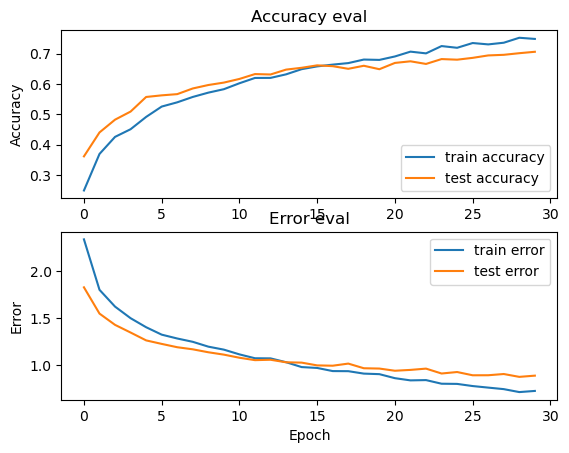

79/79 [==============================] - 0s 5ms/step - loss: 0.8701 - accuracy: 0.6980

Test accuracy: 0.6980376243591309
1/1 [==============================] - 0s 148ms/step
Target: 8, Predicted label: [8]


In [1]:
import json
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt

DATASET_PATH = "C:\Programming\Deep learning project\json_files\data.json"

def load_data(dataset_path):
    with open(dataset_path, "r") as fp:
        data = json.load(fp)
        
        #convert lists into numpy arrays
        inputs=np.array(data["mfcc"])
        targets=np.array(data["labels"])
        
        targets-=1
        print("Data successfully loaded")
        return inputs,targets


def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs

        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()


def prepare_datasets(test_size, validation_size):
    
    #load data
    X,y = load_data(DATASET_PATH)
    
    #create train/test split
    X_train, X_test, y_train , y_test = train_test_split(X, y, test_size=test_size)
    
    #create train/validation split
    X_train, X_validation, y_train , y_validation = train_test_split(X_train, y_train, test_size=validation_size)
    
    # 3d array -> (130,13,1)
    X_train = X_train[... , np.newaxis] # 4d array  -> (num_samples, 130 ,13 , 1)
    X_validation = X_validation[... , np.newaxis]
    X_test = X_test[... , np.newaxis]
    
    return X_train , X_validation, X_test, y_train, y_validation, y_test

def build_model(input_shape):
    """Generates CNN model

    :param input_shape (tuple): Shape of input set
    :return model: CNN model
    """

    # build network topology
    model = keras.Sequential()
    
    # 1st conv layer with input_shape specified
    model.add(keras.layers.Conv2D(32, (3,3), activation = "relu", input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    
    # 2nd conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    
    # 3rd conv layer
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    
    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))
    
    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model

def predict(model, X, y):
    """Predict a single sample using the trained model

    :param model: Trained classifier
    :param X: Input data
    :param y (int): Target
    """

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)

    # perform prediction
    prediction = model.predict(X)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)

    print("Target: {}, Predicted label: {}".format(y, predicted_index))


if __name__ == "__main__":
    #create train, validation and test sets
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25 , 0.2)
    
    # build the CNN net
    input_shape = (X_train.shape[1] , X_train.shape[2], X_train.shape[3])
    model = build_model(input_shape)
    
    # compile the net
    optimizer = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()
    
    # train the model
    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=30)
    
    # plot accuracy/error for training and validation
    plot_history(history)
    
    # evaluate model on test set
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
    print('\nTest accuracy:', test_acc)
    
    # make prediction
    X = X_test[100]
    y = y_test[100]
    predict(model , X,y)